# Multiclassification with pre-established folders (flow from directory method) 

I will try to build a Convolutional Neural Network using the `flow_from_directory` method for three classes:
    - Normal
    - Not-notmal/Not-pneumonia
    - Pneumonia

## Imports

### Libraries

In [1]:
# General imports
import numpy as np
import random
import pandas as pd

# System and file management
import os
import zipfile
from glob import glob

# Visualization Tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from skimage.io import imread

# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# jupyter:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
# DICOM
import pydicom
from pydicom.filereader import dcmread

# Tensoflow
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers, optimizers

from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Functions 

### Paths 

In [3]:
PATH = 'data/' # root
CSV_PATH = os.path.join(PATH,'csv') # folder with csv datasets
DICOM_PATH = os.path.join(PATH, 'pool') # folder containing all of the dicom files
JPG_PATH = os.path.join(PATH, 'pool_jpg') # folder containing all the converted jpg files
DESTINATION_PATH = os.path.join(PATH, 'sorted_balanced') # Folder where the train and test subsets will be located
MODELS_PATH = os.path.join(PATH,'model')

# Train folder
TRAIN_PATH = os.path.join(DESTINATION_PATH, 'train')
TRAIN_NORMAL_PATH = os.path.join(TRAIN_PATH, 'normal')
TRAIN_NNNP_PATH = os.path.join(TRAIN_PATH, 'nnnp')
TRAIN_PNEUMONIA_PATH = os.path.join(TRAIN_PATH, 'pneumonia')

# Validation folder
VAL_PATH = os.path.join(DESTINATION_PATH, 'validation')
VAL_NORMAL_PATH = os.path.join(VAL_PATH, 'normal')
VAL_NNNP_PATH = os.path.join(VAL_PATH, 'nnnp')
VAL_PNEUMONIA_PATH = os.path.join(VAL_PATH, 'pneumonia')

# Test folder
TEST_PATH = os.path.join(DESTINATION_PATH, 'test')
TEST_NORMAL_PATH = os.path.join(TEST_PATH, 'normal') 
TEST_NNNP_PATH = os.path.join(TEST_PATH, 'nnnp')
TEST_PNEUMONIA_PATH = os.path.join(TEST_PATH, 'pneumonia') 

### CSV

In [4]:
balanced = pd.read_csv(os.path.join(CSV_PATH, 'balanced_cxr_information.csv'))

## Model Building 

### Preprocessing images 

In [5]:
# Batch size:
BATCH_SIZE = 32
SEED = 42
IMAGE_SIZE = (512, 512)

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  # This is the source directory for training images
        target_size=(512, 512),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

val_generator = train_datagen.flow_from_directory(
        VAL_PATH,  # This is the source directory for training images
        target_size=(512, 512),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary')

Found 8416 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.


### Network creation 

In [8]:
# Our input feature map is 512x512x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(512, 512, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# max-pooling is followed by a dropout to try to avoid overfitting
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.25)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# max-pooling is followed by a dropout to try to avoid overfitting
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.25)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# max-pooling is followed by a dropout to try to avoid overfitting
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.25)(x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

#### Summary

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 32)      0     

#### Compilation 

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc', 'AUC'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fitting

#### Setting constants: 

In [12]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL = val_generator.n//val_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

#### Fitting 

In [13]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=20,
                    verbose=1)

Epoch 1/20
420/420 [==============================] - 296s 705ms/step - loss: 0.9252 - acc: 0.7668 - auc: 0.8305 - val_loss: 0.4780 - val_acc: 0.8017 - val_auc: 0.8827
Epoch 2/20
420/420 [==============================] - 172s 409ms/step - loss: 0.4092 - acc: 0.8268 - auc: 0.8982 - val_loss: 0.4270 - val_acc: 0.8133 - val_auc: 0.8924
Epoch 3/20
420/420 [==============================] - 157s 374ms/step - loss: 0.3817 - acc: 0.8367 - auc: 0.9109 - val_loss: 0.4583 - val_acc: 0.8056 - val_auc: 0.8927
Epoch 4/20
420/420 [==============================] - 157s 373ms/step - loss: 0.3612 - acc: 0.8565 - auc: 0.9228 - val_loss: 0.4184 - val_acc: 0.8228 - val_auc: 0.9062
Epoch 5/20
420/420 [==============================] - 155s 370ms/step - loss: 0.3256 - acc: 0.8719 - auc: 0.9349 - val_loss: 0.4362 - val_acc: 0.8150 - val_auc: 0.8991
Epoch 6/20
420/420 [==============================] - 155s 370ms/step - loss: 0.3039 - acc: 0.8816 - auc: 0.9433 - val_loss: 0.4101 - val_acc: 0.8428 - val_auc:

### Saving 

In [14]:
# serialize model to JSON
model_json = model.to_json()
with open("2_class_balanced_flow_dir_1.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("2_class_balanced_flow_dir_1.h5")
print("Saved model to disk")

Saved model to disk


## Predict the output

In [29]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

90/90 [==============================] - 45s 495ms/step


In [ ]:
test_data = []
test_labels = []
batch_index = 0

while batch_index <= test_generator.batch_index:
    data = next(test_generator)
    test_data.append(data[0])
    test_labels.append(data[1])
    batch_index = batch_index + 1

data_count, batch_count, w, h, c = test_data_array.shape

test_data_array=np.reshape(test_data_array, (data_count*batch_count, w, h, c))
test_labels_array = np.reshape(test_labels_array , (data_count*batch_count, -1))

In [34]:
pred_bool = (pred >0.5)
predictions = pred_bool.astype(int)

In [38]:
len(predictions)

1800

In [37]:
len(test_generator.filenames)

1804

In [32]:
predictions = pred_bool.astype(int)
columns = ['model_result']
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
#results.to_csv("results.csv",index=False)

ValueError: Length of values does not match length of index

## Metrics

dict_keys(['acc', 'val_loss', 'val_auc', 'loss', 'val_acc', 'auc'])


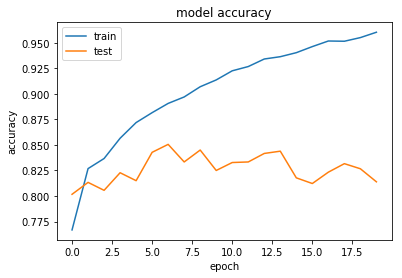

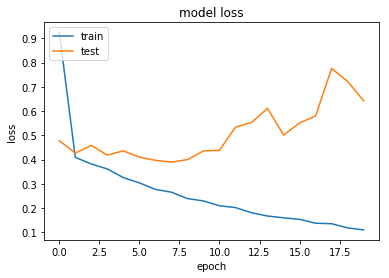

In [15]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.python.keras.utils.data_utils import Sequence
#Confusion Matrix and Classification Report
Y_pred = model.predict_generator(val_generator, STEP_SIZE_VAL)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))

Confusion Matrix


ValueError: Found input variables with inconsistent numbers of samples: [1804, 1800]